<h1><center>
Computational Notebook of "A sensitivity analysis of a regression model of ocean temperature"
</center></h1>

## Context


Can data-driven models for weather and climate predictions learn the underlying physics of the system against which they are trained? Or are they simply capable of identifying statistical patterns without any clear link to the underlying physics? In *["A sensitivity analysis of a regression model of ocean temperature"](https://www.cambridge.org/core/journals/environmental-data-science/article/sensitivity-analysis-of-a-regression-model-of-ocean-temperature/089EA5B347F262CEE0B4BDFFBA4E6FF5)*, Furner, R. at al. (2022) run a sensitivity analysis of a regression-based model of ocean temperature, trained against simulations from a 3D ocean model setup, demostrating that regression models are capable of learning much of the physics of the underlying system, such as currents and density.


### Purpose
This notebook aims to complement the science and methodological development embedded within the original paper, using an open infrastructure that allows users to combine interactive code with text and graphical objects, translating research outputs into findable, accessible, interoperable and reusable outputs and code.

### Description
*Describe the main features of the dataset/sensor, preprocessing, modelling or postprocessing routine*

### Highlights

*Provide 3-5 bullet points that convey the use case’s core procedures. Each bullet point must have a maximum of 85 characters, including spaces.*
* Highlight 1
* Highlight 2

### Contributions
*Please indicate key contributions. Notebook authors (mandatory). Optional subheadings, used in published EDS book notebooks, are Dataset originator/creator, Dataset authors, Dataset documentation, Modelling codebase, Modelling publications, Modelling funding and Pipeline documentation. Feel free to add any of them or propose new ones to attribute relevant research contributions.*

#### Notebook
* Author (role), Affiliation, GitHub alias

:::{note}
*Optional: add credits or acknowledgements to data and/or model providers or authors of code snippets*
:::

## Load libraries
List libraries according to their role e.g. system/files manipulation i.e. os (first), data handling i.e. numpy, xarray (second), visualisation i.e. holoviews (third), etc. The cell below contains two libraries, `os` and `warning` which are common among the Python Jupyter notebooks. Don't remove them.*

## Clone the MITgcm GitHub Repo

In [8]:
!git clone https://github.com/garimamalhotra/repro-challenge-team-3

Cloning into 'repro-challenge-team-3'...
remote: Enumerating objects: 353, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 353 (delta 52), reused 75 (delta 28), pack-reused 207
Receiving objects: 100% (353/353), 4.57 MiB | 24.51 MiB/s, done.
Resolving deltas: 100% (138/138), done.


## Load libraries
List libraries according to their role e.g. system/files manipulation i.e. os (first), data handling i.e. numpy, xarray (second), visualisation i.e. holoviews (third), etc. The cell below contains two libraries, `os` and `warning` which are common among the Python Jupyter notebooks. Don't remove them.*

In [9]:
from IPython.display import (
    Video, Image, HTML, display
)


## Set project structure
*The cell below creates a separate folder to save the notebook outputs. This facilitates the reader to inspect inputs/outputs stored within a defined destination folder. Don't remove the lines below.*

In [11]:
import os
notebook_folder = './notebook'
if not os.path.exists(notebook_folder):
    os.makedirs(notebook_folder)

## Dataset

The training and validation data derive from running the Massachusetts Institute of Technology general circulation model ([MITgcm](https://zenodo.org/record/4672260#.ZFgb_S-B2pY)) —a physically based model capable of simulating the ocean or the atmosphere dynamics due to isomorphisms in the governing equations. This research project relies on a simple 2° sector configuration that captures the fundamental dynamics of the ocean, including a realistic overturning circulation. This configuration features a single ocean basin, with:
+ limited topography, 
+ simplified coastlines, and 
+ constant idealized forcing. 

The domain runs from 60°S to 60° N, and is just over 20° wide in longitude. The domain is bounded by land along its northern and southern edges, and a strip of land runs along the eastern/western boundary from 60° N to 40° S.  Below this, in the southernmost 20°, the simulator has a periodic boundary condition, allowing flow that exits to the east and west to return to the domain at the western and eastern boundary. The domain has flat-bottom bathymetry of 5,000 m over most of the domain, with a 2° region of 2,500-m depth at the southernmost 20° of the eastern edge.

The simulator has:

+ 42 depth levels, with the surface layer being the thinnest at 10 m, and the bottom 10 levels being the maximum at 250 m. + 11 cells in the longitudinal direction, and
+ 78 cells in the latitudinal direction.

The simulator has a 12-hr time step, with fields output daily. We focus on daily-mean outputs.


## Download

To download the original dataset, available [here](https://zenodo.org/record/4672260). This dataset is used to train the regression model described in the paper. To download this data locally, run the following line of code. This process will take $\sim 30$ minutes.

In [12]:
!bash "../infrastructure/downloader.sh"

../infrastructure/downloader.sh: line 4: cd: ../data/raw/: No such file or directory
../infrastructure/downloader.sh: line 6: zenodo_get: command not found
Processing *.gz file...
gzip: *.gz: No such file or directory


### Overview of the Ocean Dynamics

The paper uses a  2°
  sector configuration to simulate ocean dynamics. This configuration features a single ocean basin, with limited topography, simplified coastlines, and constant idealized forcing. This has been used in a number of idealized simulations of Southern Ocean processes and their impacts on the global circulation. This configuration, while relatively simple, captures the fundamental dynamics of the ocean, including a realistic overturning circulation.

The domain runs from  60°𝑆
  to  60°𝑁
 , and is just over  20°
  wide in longitude. The domain is bounded by land along the northern (and southern) edge, and a strip of land runs along the eastern (and western) boundary from  60°
  N to  40°𝑆
  (see Figure 1a). Below this, in the southernmost 20°, the simulator has a periodic boundary condition, allowing flow that exits to the east (west) to return to the domain at the western (eastern) boundary. The domain has flat-bottom bathymetry of 5,000 m over most of the domain, with a 2° region of 2,500-m depth at the southernmost 20° of the eastern edge (i.e., the spit of land forming the eastern boundary continues to the southern boundary as a 2,500-m high subsurface ridge).

#Try - Input variables are temperature, salinity, U (East–West) and V (North–South) current components, density, U, V, and W (vertical) components of the GM bolus velocities, sea surface height (SSH), latitude, longitude, and depth. The GM bolus velocities are a parameterization of the velocities resulting from ocean eddies and are used in the GM scheme to calculate the advective effects of eddy action on tracers. For 3D variables (temperature, salinity, current components, density, and GM bolus velocity components), input features are taken from a 3 × 3 × 3 stencil of grid cells, where the center cell is the point for which we are predicting, giving 27 input features for each variable. For SSH, which is a 2D variable, the values over a 2D (3 × 3) stencil of surrounding locations are included, giving a further nine features. Lastly, the location information (latitude, longitude, and depth) at only the point we are predicting is included, giving the final three input features. All temporally changing variables are taken at the present day (t).

In [13]:
%run "../src/pipelines/graphs_section.py"


 LOADING MITGCM DATASET 


Reading in MITGCM dataset ...


FileNotFoundError: [Errno 2] No such file or directory: b'/home/jovyan/repr_3/repro-challenge-team-3/data/raw/cat_tave.nc'

Note that the depth axis is scaled to give each GCM grid cell equal spacing. The simulator shows a realistic temperature distribution with warm surface water near the equator, and cooler water near the poles and in the deep ocean. Temperature changes are largest in the very north of the domain and throughout the southern region. Though changes per day are small, they accumulate over time to give cycles of around 0.2° in some regions of the domain.

## Load data/model
*Load full dataset or model from original or mirror sources. If the license of the dataset/model permits, we suggest creating sample data (preprocessed) or model mirror for the notebook stored in a data repository e.g. Zenodo.*

### Performance of the Regressor

#### Spatial patterns of errors

These averaged errors are shown in Figure 3. Note that the regressor is only applied away from boundary and land points (in its current form, it cannot deal with spatial locations that are not surrounded on all sides by ocean points); hence, points close to land are not included in these plots.

In [ ]:
%run "../src/pipelines/spatial_patterns_errors.py"

### Sensitivity of the Regressor

#### Coefficient analysis

## Senstivity Analysis - Witholding Experiments

In this section, we run a series of withholding experiments. For each of the variables described with the exception of temperature, we train a new regressor leaving out that one variable group, for example, we train a new regressor with all the existing inputs except for salinity at all surrounding points and any multiplicative terms including salinity.

In [38]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../src/general/')
sys.path.append('../src/pipelines/')
from constants import *
import CreateDataName as cn
from IPython.display import Video, Image, HTML, display
import pickle
import os
import AssessModel as am
import gzip
import xarray as xr
import plotting as rfplt

## Withholding multiplicative terms: Figure 5, Importance of Non-Linearity

In [2]:
run_vars = {'dimension':3, 'lat':True , 'lon':True , 'dep':True , 'current':True , 'bolus_vel':True , 'sal':True , 'eta':True , 'density':True , 'poly_degree':1, 'StepSize':1, 'predict':'DelT'}
data_prefix = ''
model_prefix = 'alpha.001_'
data_name = data_prefix + cn.create_dataname(run_vars)
model_name = model_prefix+data_name
pkl_filename='../outputs/models/' + model_name+'_pickle.pkl'

In [3]:
print('Loading : ', pkl_filename)

Loading :  ../outputs/models/alpha.001_3dLatLonDepUVBolSalEtaDnsPolyDeg1_Step1_PredictDelT_pickle.pkl


In [4]:
with open(pkl_filename, 'rb') as file:
    print('opening '+pkl_filename)
    lr = pickle.load(file)

opening ../outputs/models/alpha.001_3dLatLonDepUVBolSalEtaDnsPolyDeg1_Step1_PredictDelT_pickle.pkl


/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator Ridge from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
print('Loaded : ', model_name)

Loaded :  alpha.001_3dLatLonDepUVBolSalEtaDnsPolyDeg1_Step1_PredictDelT


In [6]:
#loading input arrays - These are the processed input vectors with all the 
# polynomial input features
path='../../INPUT_OUTPUT_ARRAYS/'
inputs_tr_filename = path+'SinglePoint_'+data_name+'_InputsTr.npy'
inputs_val_filename = path+'SinglePoint_'+data_name+'_InputsVal.npy'
inputs_te_filename = path+'SinglePoint_'+data_name+'_InputsTe.npy.gz'
outputs_tr_DelT_filename = path+'SinglePoint_'+data_name+'_OutputsDelTTr.npy'
outputs_val_DelT_filename = path+'SinglePoint_'+data_name+'_OutputsDelTVal.npy'
outputs_te_DelT_filename = path+'SinglePoint_'+data_name+'_OutputsDelTTe.npy.gz'
outputs_tr_Temp_filename = path+'SinglePoint_'+data_name+'_OutputsTempTr.npy'
outputs_val_Temp_filename = path+'SinglePoint_'+data_name+'_OutputsTempVal.npy'
outputs_te_Temp_filename = path+'SinglePoint_'+data_name+'_OutputsTempTe.npy.gz'
orig_tr_Temp_filename = path+'SinglePoint_'+data_name+'_OrigTemp_Tr.npy'
orig_val_Temp_filename = path+'SinglePoint_'+data_name+'_OrigTemp_Val.npy'
clim_tr_Temp_filename = path+'SinglePoint_'+data_name+'_ClimTemp_Tr.npy'
clim_val_Temp_filename = path+'SinglePoint_'+data_name+'_ClimTemp_Val.npy'

In [7]:
#Loading Input Arrays
norm_inputs_tr=np.load(inputs_tr_filename)
norm_inputs_val=np.load(inputs_val_filename)
norm_inputs_te=np.load(gzip.GzipFile(inputs_te_filename,'r'))

In [8]:
#Loading Output Arrays
norm_outputs_tr_DelT=np.load(outputs_tr_DelT_filename)
norm_outputs_val_DelT=np.load(outputs_val_DelT_filename)
norm_outputs_te_DelT=np.load(gzip.GzipFile(outputs_te_DelT_filename,'r'))

In [9]:
norm_outputs_tr_Temp=np.load(outputs_tr_Temp_filename)
norm_outputs_val_Temp=np.load(outputs_val_Temp_filename)
norm_outputs_te_Temp=np.load(gzip.GzipFile(outputs_te_Temp_filename,'r'))

In [10]:
#Loading persistence arrays to calculate climatology
orig_tr_Temp=np.load(orig_tr_Temp_filename)
orig_val_Temp=np.load(orig_val_Temp_filename) 
clim_tr_Temp=np.load(clim_tr_Temp_filename)
clim_val_Temp=np.load(clim_val_Temp_filename)

In [11]:
if run_vars['predict'] == 'DelT':
       norm_outputs_tr  = norm_outputs_tr_DelT
       norm_outputs_val = norm_outputs_val_DelT

elif run_vars['predict'] == 'Temp':
       norm_outputs_tr = norm_outputs_tr_Temp
       norm_outputs_val = norm_outputs_val_Temp

In [12]:
# predict values
print('predict values')
norm_lr_predicted_tr = lr.predict(norm_inputs_tr).reshape(-1,1).astype('float64')
norm_lr_predicted_val = lr.predict(norm_inputs_val).reshape(-1,1).astype('float64')

predict values


In [13]:
norm_lr_predicted_tr.shape

(648440, 1)

In [14]:
# Read in mean and std
path='../../INPUT_OUTPUT_ARRAYS/'
mean_std_file = path+'SinglePoint_'+data_name+'_MeanStd.npz'
zip_mean_std_file = mean_std_file+'.gz' 
if os.path.isfile(mean_std_file):
       mean_std_data = np.load(mean_std_file)
elif os.path.isfile(zip_mean_std_file):
       os.system("gunzip %s" % (zip_mean_std_file))
       mean_std_data = np.load(mean_std_file)
       os.system("gunzip %s" % (mean_std_file))
input_mean  = mean_std_data['arr_0']
input_std   = mean_std_data['arr_1']
output_DelT_mean = mean_std_data['arr_2']
output_DelT_std  = mean_std_data['arr_3']
output_Temp_mean = mean_std_data['arr_4']
output_Temp_std  = mean_std_data['arr_5']

if run_vars['predict'] == 'DelT':
       output_mean = output_DelT_mean
       output_std = output_DelT_std
elif run_vars['predict'] == 'Temp':
       output_mean = output_Temp_mean
       output_std = output_Temp_std

In [15]:
# define denormalising function
def denormalise_data(norm_data,mean,std):
    denorm_data = norm_data * std + mean
    return denorm_data

In [16]:
# denormalise the predictions and true outputs   
denorm_lr_predicted_tr = denormalise_data(norm_lr_predicted_tr, output_mean, output_std)
denorm_lr_predicted_val = denormalise_data(norm_lr_predicted_val, output_mean, output_std)
denorm_outputs_tr = denormalise_data(norm_outputs_tr, output_mean, output_std)
denorm_outputs_val = denormalise_data(norm_outputs_val, output_mean, output_std)

In [17]:
#------------------
# Assess the model
#------------------
# Calculate 'persistance' score - persistence prediction is just zero everywhere as we're predicting the trend
predict_persistance_tr = np.zeros(denorm_outputs_tr.shape)
predict_persistance_val = np.zeros(denorm_outputs_val.shape)

In [18]:
top    = max(max(denorm_outputs_tr), max(denorm_lr_predicted_tr), max(denorm_outputs_val), max(denorm_lr_predicted_val))
top    = top + 0.1*abs(top)
bottom = min(min(denorm_outputs_tr), min(denorm_lr_predicted_tr), min(denorm_outputs_val), min(denorm_lr_predicted_val))
bottom = bottom - 0.1*abs(top)

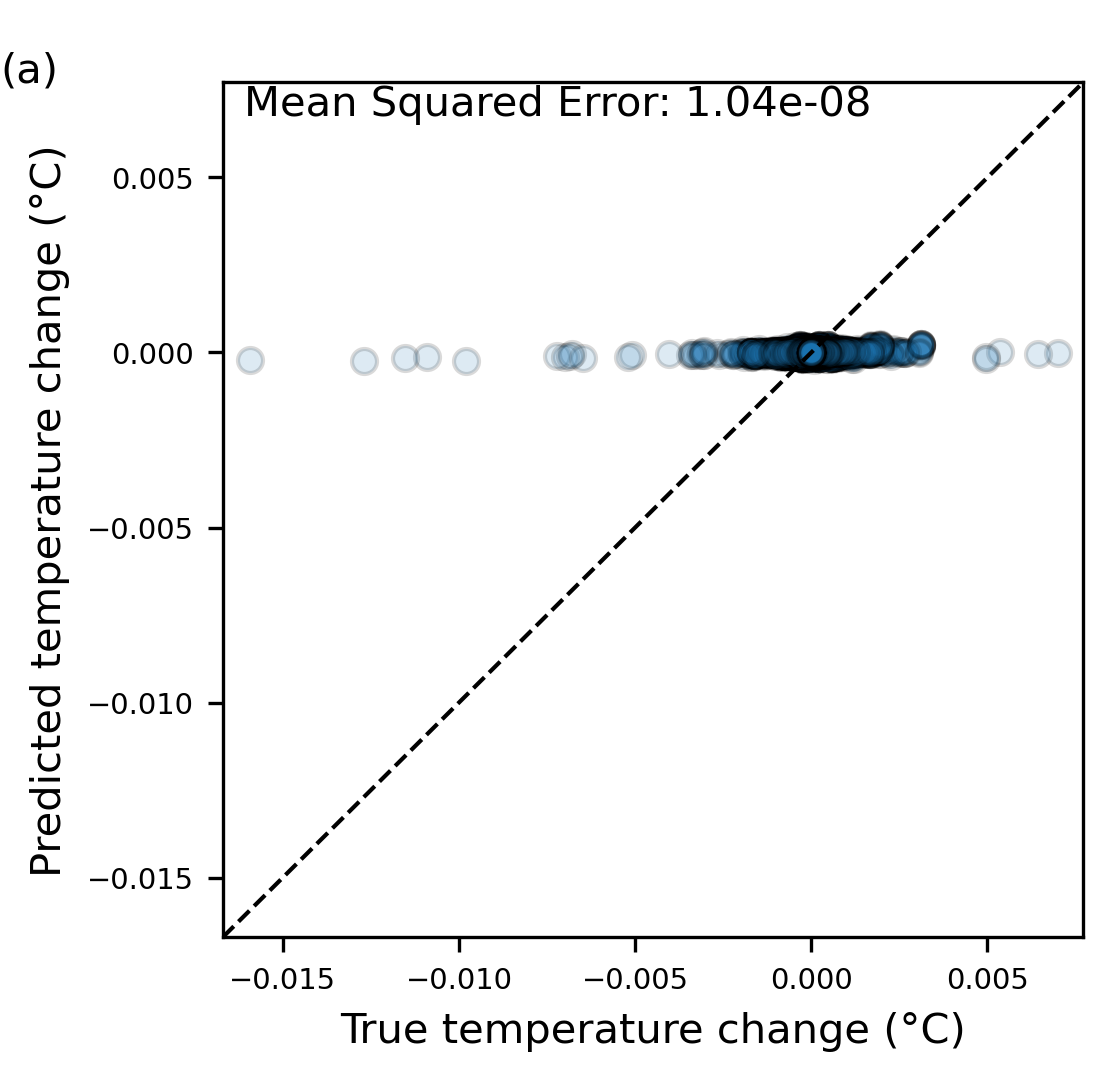

In [19]:
am.plot_scatter(model_name, denorm_outputs_tr, denorm_lr_predicted_tr, name='train', top=top, bottom=bottom, text='(a)',save=False)

We see that, without multiplicative terms, the model can capture the mean behavior of the system (zero change in temperature) but is unable to capture any of the variability. This mean behavior alone does not provide useful forecasts, as can be seen from the statistics for this experiment. 
 Nonlinearity is shown to be critical to modeling the variability of temperature change.

## Withholding 3D structure: Figure 6, Impact of vertical structure

To assess how information about the vertical structure of the ocean impacts predictions, we look at spatially averaged errors from the model trained with only a 2D neighborhood of inputs, along with the difference in error between this and the control run from previous Section

In [24]:
DIR='../data/raw/'
MITGCM_filename=DIR+'cat_tave.nc'
#-------------------
# Read in land mask 
#-------------------
MITGCM_ds = xr.open_dataset(MITGCM_filename)
land_mask = MITGCM_ds['Mask'].values
da_T = MITGCM_ds['Ttave'].values

In [30]:
#Loading the 2D model 
run_vars={'dimension':2, 'lat':True , 'lon':True, 'dep':True , 'current':True , 'bolus_vel':True , 'sal':True , 'eta':True , 'density':True , 'poly_degree':2, 'StepSize':1, 'predict':'DelT'}
data_prefix=''
exp_prefix = ''
model_prefix = 'alpha.001_'
data_name = data_prefix + cn.create_dataname(run_vars)
model_name = model_prefix+data_name
exp_name = exp_prefix+model_name
cntrl_name = exp_prefix+model_prefix+data_prefix+'3dLatLonDepUVBolSalEtaDnsPolyDeg2_Step1_PredictDelT'

In [31]:
exp_name

'alpha.001_2dLatLonDepUVBolSalEtaDnsPolyDeg2_Step1_PredictDelT'

Loading absolute errors from predictions across the grid at 500 different times averaged to give a spatial pattern of errors.

In [32]:
#------------------------
print('reading in data')
#------------------------
rootdir='/home/jovyan/ops/lr_Outputs/'
data_filename=rootdir+'ITERATED_PREDICTION_ARRAYS/'+exp_name+'_AveragedSinglePredictions.nc'
ds = xr.open_dataset(data_filename)
da_Av_Error=ds['Av_Errors'].values
da_Av_AbsError=ds['Av_AbsErrors'].values
da_wtd_Av_Error=ds['Weighted_Av_Errors'].values
da_CC=ds['Cor_Coef'].values

cntrl_filename = rootdir+'ITERATED_PREDICTION_ARRAYS/'+cntrl_name+'_AveragedSinglePredictions.nc'
cntrl_ds = xr.open_dataset(cntrl_filename)
da_cntrl_Av_AbsError=cntrl_ds['Av_AbsErrors'].values
da_cntrl_CC=cntrl_ds['Cor_Coef'].values

reading in data


In [33]:
#Plotting Cross-section at 13 degrees East
point = [ 2, 8, 6]
level = point[0]
y_coord = point[1]
x_coord = point[2]

In [34]:
# mask data
Av_Error = np.where(land_mask==1, da_Av_Error, np.nan)
Av_AbsError = np.where(land_mask==1, da_Av_AbsError, np.nan)
wtd_Av_Error = np.where(land_mask==1, da_wtd_Av_Error, np.nan)
Cntrl_Av_AbsError = np.where(land_mask==1, da_cntrl_Av_AbsError, np.nan)
Cor_Coef = np.where(land_mask==1, da_CC, np.nan)
Cntrl_Cor_Coef = np.where(land_mask==1, da_cntrl_CC, np.nan)

In [35]:
z_size = Av_Error.shape[0]
y_size = Av_Error.shape[1]
x_size = Av_Error.shape[2]

print('Av_Error.shape')
print(Av_Error.shape)

Av_Error.shape
(42, 78, 11)


Plotting the absolute error from predictions across the grid at 500 different times averaged to give a spatial pattern of errors. 

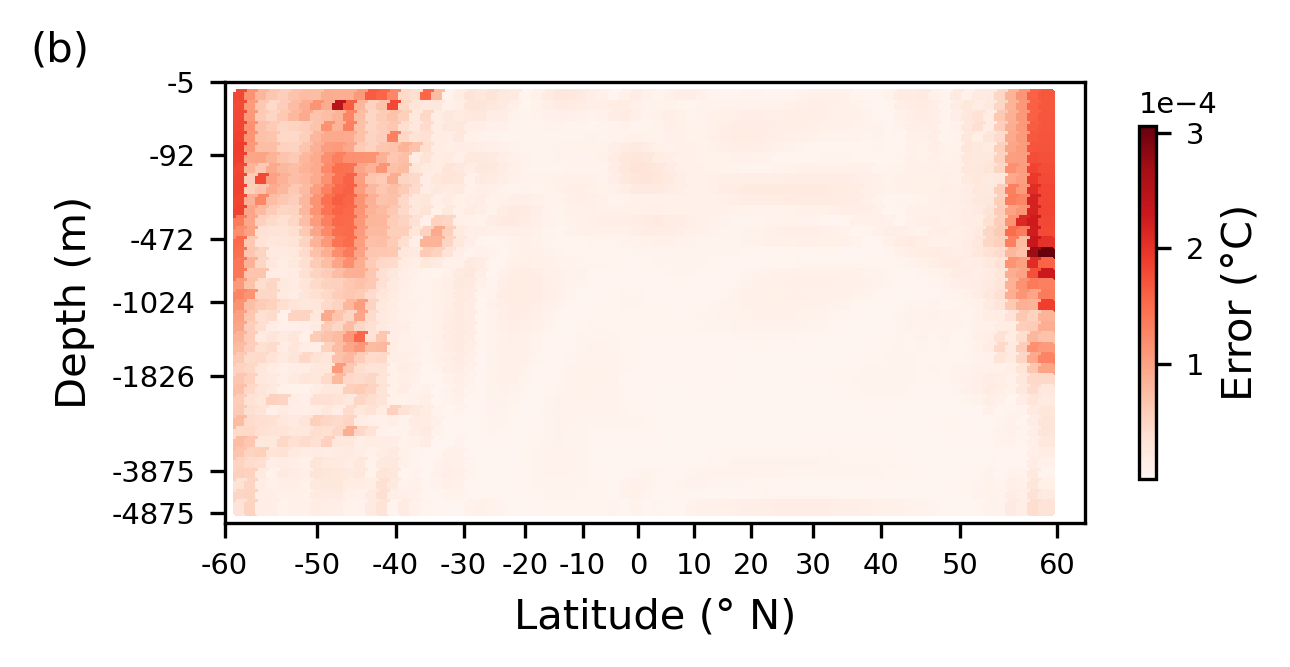

In [41]:
fig, ax, im = rfplt.plot_xconst_crss_sec(Av_AbsError[:,:,:], 'Averaged Absolute Errors', x_coord,
                                         MITGCM_ds['X'].values, MITGCM_ds['Y'].values, MITGCM_ds['Z'].values,
                                         text='(b)', title=None, min_value=0.0, max_value=0.000306, cmap='Reds',
                                         #text='(a)', title=None, min_value=0.0, max_value=0.000306, cmap='Reds',
                                         cbar_label=cbar_label, Sci=True)

Plotting the difference between this and the control run, with areas shaded in red indicating where the error has increased as a consequence of withholding information about the vertical structure, and blue indicating areas where the predictions are improved.

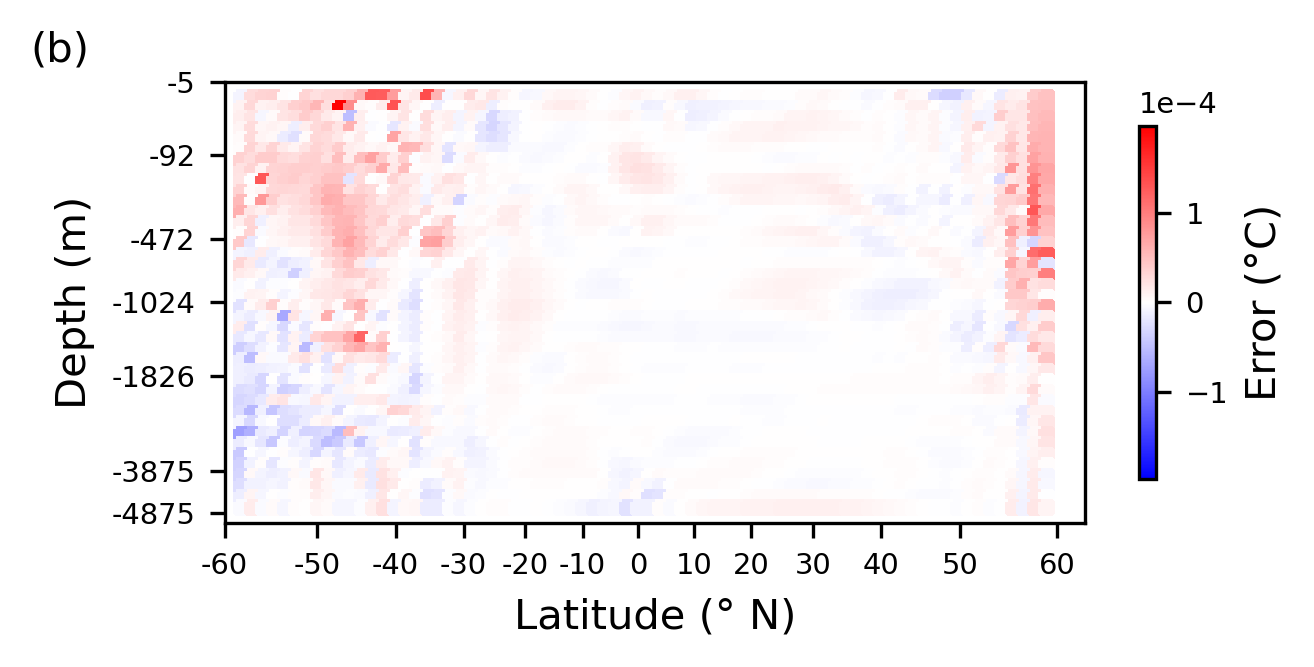

In [42]:
#Plot x cross section of difference between cntrl and exp
fig, ax, im = rfplt.plot_xconst_crss_sec(Av_AbsError[:,:,:]-Cntrl_Av_AbsError, 'Diff in Averaged Absolute Errors with Control Run', x_coord,
                                         MITGCM_ds['X'].values, MITGCM_ds['Y'].values, MITGCM_ds['Z'].values,
                                         text='(b)', title=None, min_value=None, max_value=None, diff=True,
                                         cbar_label=cbar_label, Sci=True)
plt.savefig(rootdir+'PLOTS/'+model_name+'/'+exp_name+'_AvAbsErrors_DiffwCntrl_x'+str(x_coord)+'.eps', bbox_inches = 'tight', pad_inches = 0.1, format='eps')

Interestingly, this regressor shows some regions (the deep water in the south of the domain) where the errors are notably improved in a regressor using only 2D information. In this work, we have developed a regressor which learns one equation to be applied across all grid boxes in the domain. We optimize for best performance averaged over all relevant grid cells, but this does not enforce the best possible performance over each individual grid point/region, and so some of the resultant models will favor certain types of dynamics more than others. Given this, it is not unexpected that the new equations discovered for the withholding experiments (which again optimize for best performance averaged over the entire domain interior) may outperform the control in some locations, despite being poorer overall. Here, we see that the control model is able to perform well across the domain, and optimizes for good performance overall (see Figure 3b), rather than the much more varied performance seen in the withholding experiments (Figure 6b). It seems that as the model which withholds vertical information is not capable of performing well in many regions of the domain, a solution is found which highly optimizes performance in other regions to minimize error overall.

## Withholding Currents: Figure 7, Impact of currents

In [44]:
run_vars={'dimension':3, 'lat':True , 'lon':True, 'dep':True , 'current':False , 'bolus_vel':True , 'sal':True , 'eta':True , 'density':True , 'poly_degree':2, 'StepSize':1, 'predict':'DelT'}
data_prefix=''
exp_prefix = ''
model_prefix = 'alpha.001_'
data_name = data_prefix + cn.create_dataname(run_vars)
model_name = model_prefix+data_name
exp_name = exp_prefix+model_name
cntrl_name = exp_prefix+model_prefix+data_prefix+'3dLatLonDepUVBolSalEtaDnsPolyDeg2_Step1_PredictDelT'

In [45]:
exp_name

'alpha.001_3dLatLonDepBolSalEtaDnsPolyDeg2_Step1_PredictDelT'

In [46]:
#------------------------
print('reading in data')
#------------------------
rootdir='/home/jovyan/ops/lr_Outputs/'
data_filename=rootdir+'ITERATED_PREDICTION_ARRAYS/'+exp_name+'_AveragedSinglePredictions.nc'
ds = xr.open_dataset(data_filename)
da_Av_Error=ds['Av_Errors'].values
da_Av_AbsError=ds['Av_AbsErrors'].values
da_wtd_Av_Error=ds['Weighted_Av_Errors'].values
da_CC=ds['Cor_Coef'].values

cntrl_filename = rootdir+'ITERATED_PREDICTION_ARRAYS/'+cntrl_name+'_AveragedSinglePredictions.nc'
cntrl_ds = xr.open_dataset(cntrl_filename)
da_cntrl_Av_AbsError=cntrl_ds['Av_AbsErrors'].values
da_cntrl_CC=cntrl_ds['Cor_Coef'].values

reading in data


In [47]:
# mask data
Av_Error = np.where(land_mask==1, da_Av_Error, np.nan)
Av_AbsError = np.where(land_mask==1, da_Av_AbsError, np.nan)
wtd_Av_Error = np.where(land_mask==1, da_wtd_Av_Error, np.nan)
Cntrl_Av_AbsError = np.where(land_mask==1, da_cntrl_Av_AbsError, np.nan)
Cor_Coef = np.where(land_mask==1, da_CC, np.nan)
Cntrl_Cor_Coef = np.where(land_mask==1, da_cntrl_CC, np.nan)

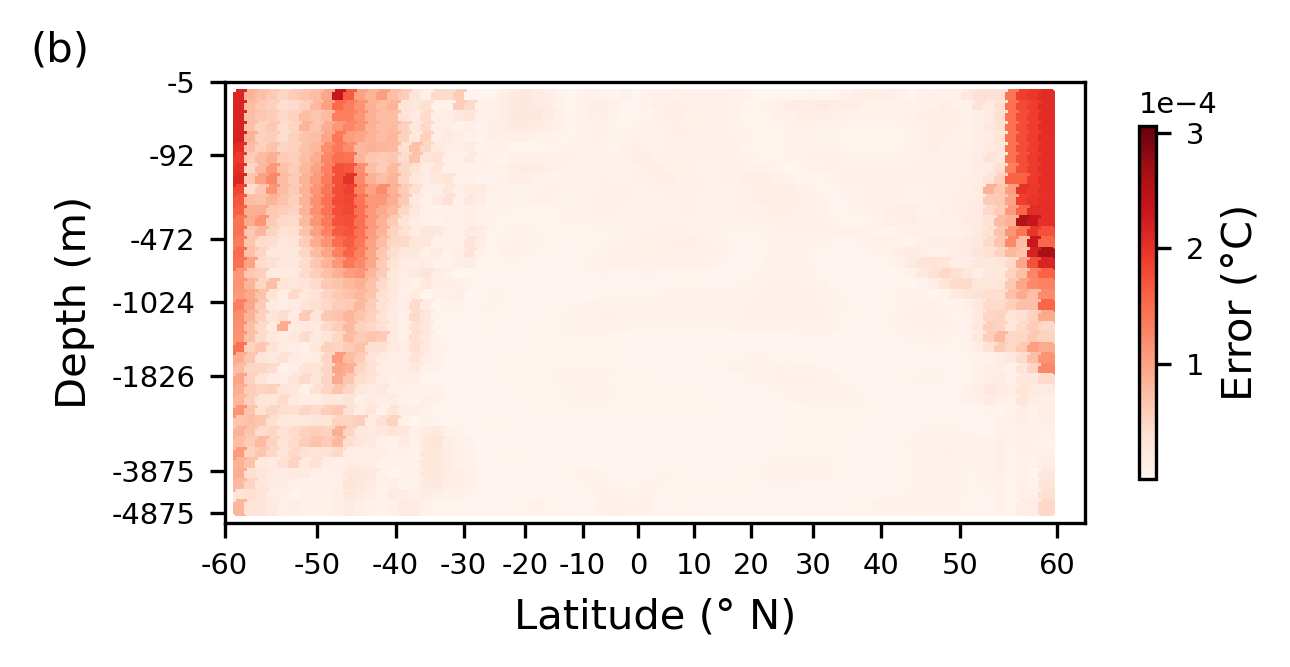

In [48]:
ig, ax, im = rfplt.plot_xconst_crss_sec(Av_AbsError[:,:,:], 'Averaged Absolute Errors', x_coord,
                                         MITGCM_ds['X'].values, MITGCM_ds['Y'].values, MITGCM_ds['Z'].values,
                                         text='(b)', title=None, min_value=0.0, max_value=0.000306, cmap='Reds',
                                         #text='(a)', title=None, min_value=0.0, max_value=0.000306, cmap='Reds',
                                         cbar_label=cbar_label, Sci=True)

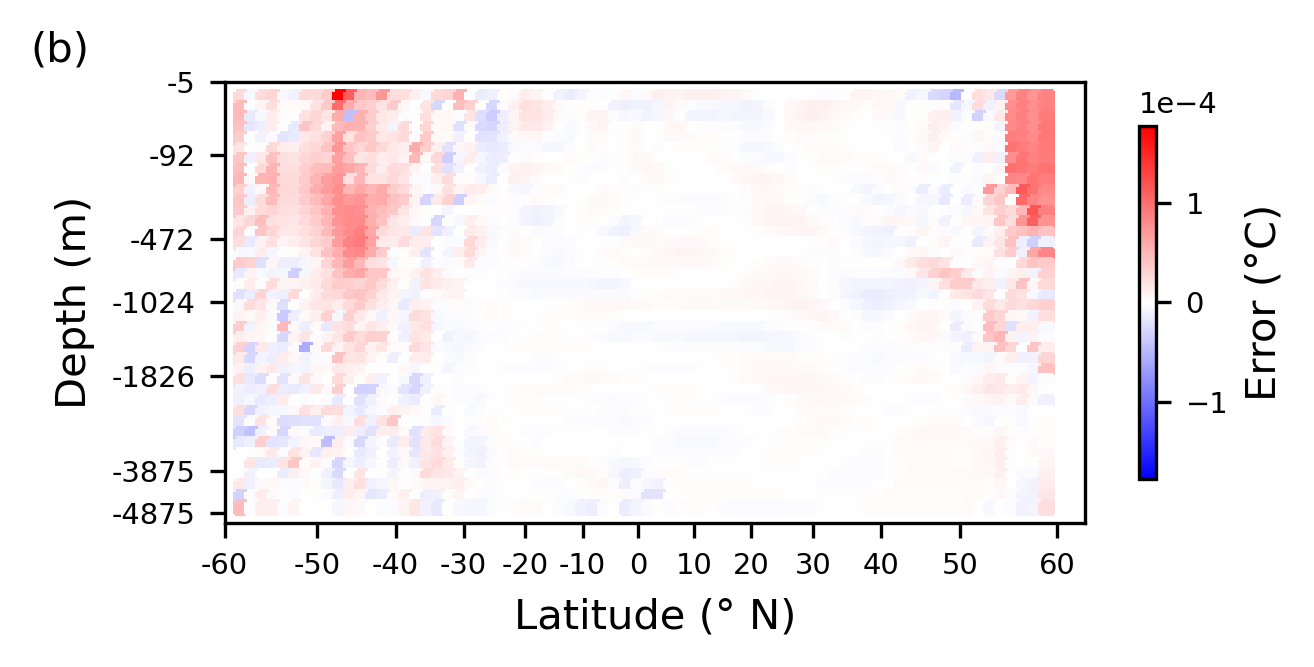

In [49]:
#Plot x cross section of difference between cntrl and exp
fig, ax, im = rfplt.plot_xconst_crss_sec(Av_AbsError[:,:,:]-Cntrl_Av_AbsError, 'Diff in Averaged Absolute Errors with Control Run', x_coord,
                                         MITGCM_ds['X'].values, MITGCM_ds['Y'].values, MITGCM_ds['Z'].values,
                                         text='(b)', title=None, min_value=None, max_value=None, diff=True,
                                         cbar_label=cbar_label, Sci=True)
plt.savefig(rootdir+'PLOTS/'+model_name+'/'+exp_name+'_AvAbsErrors_DiffwCntrl_x'+str(x_coord)+'.eps', bbox_inches = 'tight', pad_inches = 0.1, format='eps')

## Summary
*Provide 3-5 bullet points summarising the main aspects of the dataset and tools covered in the notebook.*

* Sentence 1 e.g. `tool-name` to perform...
* Sentence 2 e.g. `tool-name` to perform...

## Additional information
**Dataset**: Type here details of dataset(s) version.

**Codebase**: Type here details of codebase version (only for notebooks categorised under modelling/preprocesing/post-processing themes).

**License**: The code in this notebook is licensed under the MIT License. The Environmental Data Science book is licensed under the Creative Commons by Attribution 4.0 license. See further details [here](https://github.com/alan-turing-institute/environmental-ds-book/blob/master/LICENSE.md).

**Contact**: If you have any suggestion or report an issue with this notebook, feel free to [create an issue](https://github.com/alan-turing-institute/environmental-ds-book/issues/new/choose) or send a direct message to [environmental.ds.book@gmail.com](mailto:environmental.ds.book@gmail.com).

In [ ]:
from datetime import date
print(f'Last tested: {date.today()}')